# `pretty_midi` tutorial

This tutorial goes over the functionality of [pretty_midi](http://github.com/craffel/pretty_midi), a Python library for creating, manipulating, and extracting information from MIDI files.  For more information, check [the docs](http://craffel.github.io/pretty-midi/).

In [1]:
# Uncomment to install dependecies to run on Colab:
#!sudo apt-get install fluidsynth
#!pip install pretty_midi mir_eval pyfluidsynth

# For Python2.6 compatibility
from __future__ import print_function

import pretty_midi
import numpy as np
# For plotting
import mir_eval.display
import librosa.display
import matplotlib.pyplot as plt
%matplotlib inline
# For putting audio in the notebook
import IPython.display


## Building a MIDI file from scratch

To start, we'll build a MIDI sequence from the ground up.  More specifically, we'll build up a MIDI "object" using `pretty_midi`'s representation of MIDI (which we can optionally write out to a MIDI file later on).  This representation is actually a little different than standard MIDI files (it's intended to be less ambiguous and a little easier to work with), but the two are mostly interchangeable.  Relevant differences will be pointed out as we go.

### The `PrettyMIDI` class

The `PrettyMIDI` class is the main container in `pretty_midi`.  It stores not only all of the events that constitute the piece, but also all of the timing information, meta-events (like key signature changes), and utility functions for manipulating, writing out, and inferring information about the MIDI data it contains.

In [2]:
# Construct a PrettyMIDI object.
# We'll specify that it will have a tempo of 80bpm.
pm = pretty_midi.PrettyMIDI(initial_tempo=80)

### The `Instrument` class

One of the most important functions of the `PrettyMIDI` class is to hold a `list` of `Instrument` class instances.  Each `Instrument` is able to store different events (for example, notes) which are meant to be played on a given general MIDI instrument (for example, instrument 42, "Cello").  The `Instrument` class also has functions for extracting useful information based solely on the events that occur on that particular instrument.

In [3]:
# The instruments list from our PrettyMIDI instance starts empty
print(pm.instruments)

[]


In [4]:
# Let's add a Cello instrument, which has program number 42.
# pretty_midi also keeps track of whether each instrument is a "drum" instrument or not
# because drum/non-drum instruments share program numbers in MIDI.
# You can also optionally give the instrument a name,
# which corresponds to the MIDI "instrument name" meta-event.
inst = pretty_midi.Instrument(program=42, is_drum=False, name='my cello')
pm.instruments.append(inst)

### Event containers

`pretty_midi` has individual classes for holding MIDI events: `Note`, `PitchBend`, and `ControlChange`.  These classes store information analogous to their corresponding MIDI events.  The `Instrument` class has separate `list`s for each of these event types.

#### Note

The `Note` class represents a MIDI note, which has a pitch, a start time, and and end time.  Notes have a pitch number from 0 to 127, representing the notes from C-1 to G9.  In addition, notes have a velocity (volume) from 1 to 127, from quietest to loudest.  The way `pretty_midi` stores notes is slightly different from standard MIDI, in the sense that in MIDI the note-on and note-off events are separate and their correspondences must be guessed from the MIDI stream.  `pretty_midi` keeps the start and end times of a note coupled together, so things are less ambiguous.  Furthermore, `pretty_midi` stores all times in terms of actual wall clock time from the start of the MIDI sequence, rather than in "ticks" (discussed further below).  This is much easier to work with!

In [5]:
# Let's add a few notes to our instrument
velocity = 100
for pitch, start, end in zip([60, 62, 64], [0.2, 0.6, 1.0], [1.1, 1.7, 2.3]):
    inst.notes.append(pretty_midi.Note(velocity, pitch, start, end))
print(inst.notes)

[Note(start=0.200000, end=1.100000, pitch=60, velocity=100), Note(start=0.600000, end=1.700000, pitch=62, velocity=100), Note(start=1.000000, end=2.300000, pitch=64, velocity=100)]


#### Pitch bends

Since MIDI notes are all defined to have a specific integer pitch value, in order to represent arbitrary pitch frequencies we need to use pitch bends.  A `PitchBend` class in `pretty_midi` holds a time (in seconds) and a pitch offset.  The pitch offset is an integer in the range [-8192, 8191], which in General MIDI spans the range from -2 to +2 semitones.  As with `Note`s, the `Instrument` class has a `list` for `PitchBend` class instances.

In [6]:
# We'll just do a 1-semitone pitch ramp up
n_steps = 512
bend_range = 8192//2
for time, pitch in zip(np.linspace(1.5, 2.3, n_steps),
                       range(0, bend_range, bend_range//n_steps)):
    inst.pitch_bends.append(pretty_midi.PitchBend(pitch, time))

####  Control changes

The `Instrument` class also holds control changes.  Control changes include things like modulation, reverb, etc.,  which may or may not be supported by a given General MIDI synthesizer.  As usual, they are stored in an `Instrument`'s `control_changes` `list`.  We won't be covering them here.

### Putting it all together

To give you a taste of what sorts of analysis you can do (which we'll cover in more detail in the next section), here are some examples using the (simple) MIDI sequence we just constructed.

#### Plotting a piano roll

A great way to visualize MIDI data is via a piano roll, which is a time-frequency matrix where each row is a different MIDI pitch and each column is a different slice in time.  `pretty_midi` can produce piano roll matrices for each indivual instrument (via `Instrument.get_piano_roll`) or the entire `PrettyMIDI` object (summed across instruments, via `PrettyMIDI.get_piano_roll`).  The spacing in time between subsequent columns of the matrix is determined by the `fs` parameter.

C:\Users\Andrea\AppData\Local\Temp\ipykernel_12944\2914792024.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


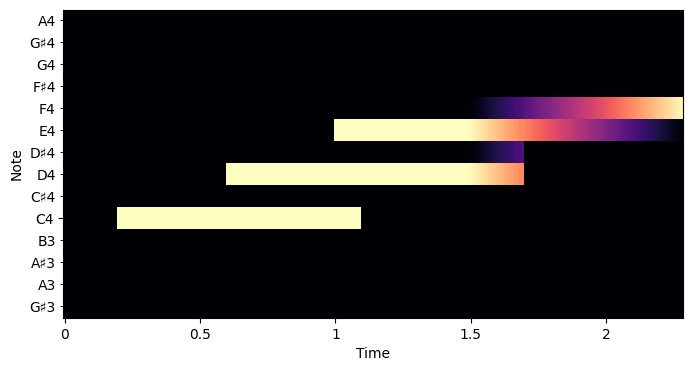

In [7]:
def plot_piano_roll(pm, start_pitch, end_pitch, fs=100):
    # Use librosa's specshow function for displaying the piano roll
    librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],
                             hop_length=1, sr=fs, x_axis='time', y_axis='cqt_note',
                             fmin=pretty_midi.note_number_to_hz(start_pitch))

plt.figure(figsize=(8, 4))
plot_piano_roll(pm, 56, 70)
# Note the blurry section between 1.5s and 2.3s - that's the pitch bending up!

#### Sonification

`pretty_midi` has two main ways to sonify MIDI data: the `synthesize` and `fluidsynth` functions.  `synthesize` is a simple and rudimentary method which just synthesizes each note as a sine wave.  `fluidsynth` uses the Fluidsynth program along with a SoundFont file (a simple one is installed alongside `pretty_midi`) to create a General MIDI synthesis.  Note that you must have the Fluidsynth program installed to use the `fluidsynth` function.  Both the `Instrument` and `PrettyMIDI` classes have these methods; the `PrettyMIDI` versions just sum up the syntheses for all of the contained instruments.

In [8]:
# Synthesis frequency
fs = 16000
IPython.display.Audio(pm.synthesize(fs=16000), rate=16000)
# Sounds like sine waves...

In [9]:
IPython.display.Audio(pm.fluidsynth(fs=16000), rate=16000)
# Sounds (kind of) like a cello!

#### Writing it out

Finally, we can easily write out what we just made to a standard MIDI file via the `write` function.  `pretty_midi` puts each `Instrument` on a separate track in the MIDI file.  Note that because `pretty_midi` uses a slightly different representation of MIDI data (for example, representing time as absolute seconds rather than as ticks), the information written out to the file will be slightly different.  Otherwise, everything in your `PrettyMIDI` object will be included in the generated MIDI file.

In [10]:
pm.write('out.mid')

## Parsing a MIDI file

The other intended use of `pretty_midi` is to parse MIDI files, so that they can be manipulated and analyzed.  Loading in a MIDI file is simple.  `pretty_midi` should be able to handle all valid MIDI files, and will raise an Exception of the MIDI data is corrupt.

In [11]:
# We'll load in the example.mid file distributed with pretty_midi
pm = pretty_midi.PrettyMIDI("../data/clean_midi/883/Hanno ucciso l'uomo ragno.mid")

C:\Users\Andrea\AppData\Local\Temp\ipykernel_12944\2914792024.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


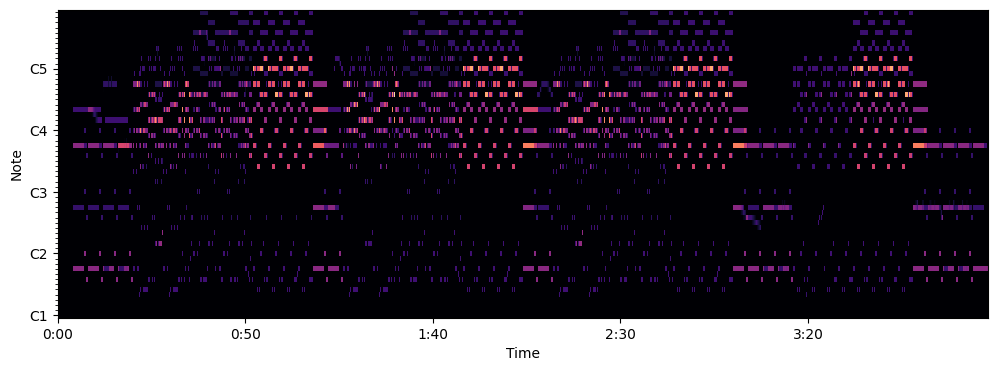

In [12]:
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)

In [13]:
# Let's look at what's in this MIDI file
print('There are {} time signature changes'.format(len(pm.time_signature_changes)))
print('There are {} instruments'.format(len(pm.instruments)))
print('Instrument 3 has {} notes'.format(len(pm.instruments[0].notes)))
print('Instrument 4 has {} pitch bends'.format(len(pm.instruments[4].pitch_bends)))
print('Instrument 5 has {} control changes'.format(len(pm.instruments[5].control_changes)))

There are 0 time signature changes
There are 15 instruments
Instrument 3 has 213 notes
Instrument 4 has 0 pitch bends
Instrument 5 has 8 control changes


#### A note on timing information

As discussed above, `pretty_midi` stores the time of different events in absolute seconds.  This is different from MIDI, where the timing of events is determined in terms of relative "ticks" from the previous event.  The amount of time each tick corresponds to depends on the current tempo and the file's resolution.  Naturally, this is a woefully difficult way to deal with timing, which is why `pretty_midi` represents time in terms of absolute seconds.  Hoever, we don't want to totally get rid of the metrical grid, so `pretty_midi` retains a mapping between times and ticks which is based on tempo change events.

In [14]:
# What's the start time of the 10th note on the 3rd instrument?
print(pm.instruments[2].notes[10].start)
# What's that in ticks?
tick = pm.time_to_tick(pm.instruments[2].notes[10].start)
print(tick)
# Note we can also go in the opposite direction
print(pm.tick_to_time(int(tick)))

235.97916666666666
90616
235.97916666666666


### Modifying the MIDI data

Anything we did above when creating a MIDI file can now be done to the parsed MIDI object.  For example, we can add or remove notes from instruments, add or remove instruments from the MIDI sequence, or even modify the attributes of individual events.

In [15]:
# Let's shift the entire piece up by 2 semitones.
for instrument in pm.instruments:
    # Skip drum instruments - their notes aren't pitched!
    if instrument.is_drum:
        continue
    for note in instrument.notes:
        note.pitch += 2

#### Adjusting timing

There are two ways to modify the timing of a MIDI sequence in `pretty_midi`.  The first way is to directly changing the timing attributes of all of the events in the `PrettyMIDI` object (and its `Instrument`s).  While simple, the issue with this approach is that the timing of these events will no longer match the metrical information in the MIDI file.  The second approach is to use the `adjust_times` function, which effectively takes an original and adjusted temporal grid and correctly performs the warping - ensuring that the timing/metrical information remains correct.  This can also be used for cropping out portions of the MIDI file.

In [16]:
# Get the length of the MIDI file
length = pm.get_end_time()
# This will effectively slow it down to 110% of its original length
pm.adjust_times([0, length], [0, length*1.1])
# Let's check what time our tick from above got mapped to - should be 1.1x
print(pm.tick_to_time(tick))

259.57708333333335


c:\Users\Andrea\Documents\Università\Magistrale\Deeplearning\NNDL-project\venv_deep\Lib\site-packages\pretty_midi\pretty_midi.py:1093: UserWarning: tick should be an int.
  warnings.warn('tick should be an int.')


### Analyzing the MIDI data

`pretty_midi` contains extensive functionality for deriving information from a MIDI sequence.  Much of this information is not readibly accessible from the MIDI file itself, so a primary goal of `pretty_midi` is to take care of all of the parsing and analysis in a correct, efficient, and easy-to-use way.

#### Timing information

Inferring, for example, the beat or downbeat times from a MIDI file requires keeping careful track of tempo change and time signature change events.  `pretty_midi` handles this for you, and keeps them correct when you use `adjust_times`.

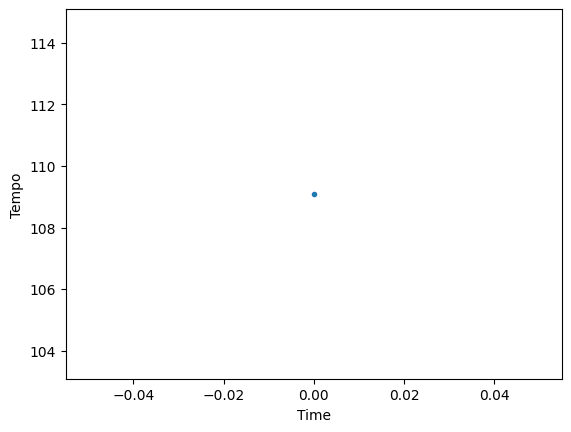

In [17]:
# Plot the tempo changes over time
# Many MIDI files won't have more than one tempo change event,
# but this particular file was transcribed to somewhat closely match the original song.
times, tempo_changes = pm.get_tempo_changes()
plt.plot(times, tempo_changes, '.')
plt.xlabel('Time')
plt.ylabel('Tempo');

C:\Users\Andrea\AppData\Local\Temp\ipykernel_12944\2914792024.py:3: UserWarning: Frequency axis exceeds Nyquist. Did you remember to set all spectrogram parameters in specshow?
  librosa.display.specshow(pm.get_piano_roll(fs)[start_pitch:end_pitch],


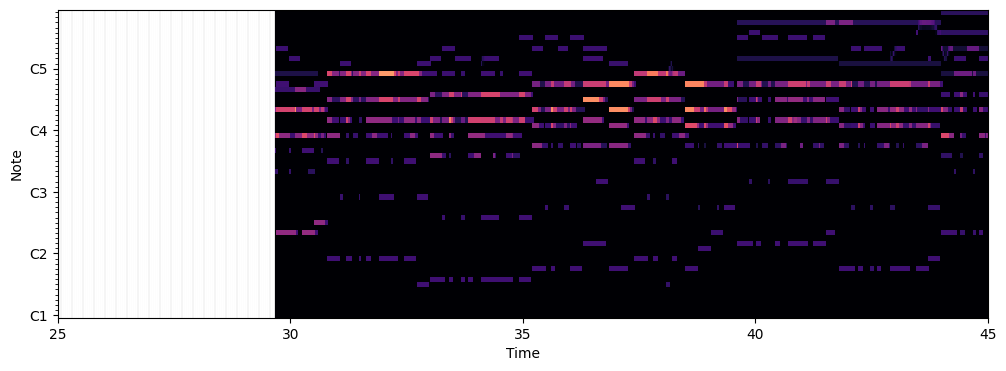

In [ ]:
# Get and downbeat times
beats = pm.get_beats()
downbeats = pm.get_downbeats()
# Plot piano roll
plt.figure(figsize=(12, 4))
plot_piano_roll(pm, 24, 84)
ymin, ymax = plt.ylim()
# Plot beats as grey lines, downbeats as white lines
mir_eval.display.events(beats, base=ymin, height=ymax, color='#AAAAAA')
mir_eval.display.events(downbeats, base=ymin, height=ymax, color='#FFFFFF', lw=2)
# Only display 20 seconds for clarity
plt.xlim(25, 45)

#### Harmonic information

Beyond metrical information, `pretty_midi` contains a few utility functions for measuring statistics about the harmonic content of the MIDI sequence.  However, it's also designed so that additional analysis is easy.

Text(0, 0.5, 'Proportion')

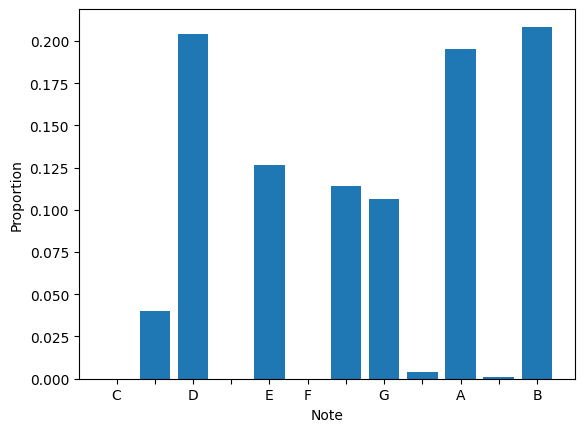

In [19]:
# Plot a pitch class distribution - sort of a proxy for key
plt.bar(np.arange(12), pm.get_pitch_class_histogram());
plt.xticks(np.arange(12), ['C', '', 'D', '', 'E', 'F', '', 'G', '', 'A', '', 'B'])
plt.xlabel('Note')
plt.ylabel('Proportion')

In [20]:
# Let's count the number of transitions from C to D in this song
n_c_to_d = 0
for instrument in pm.instruments:
    # Drum instrument notes don't have pitches!
    if instrument.is_drum:
        continue
    for first_note, second_note in zip(instrument.notes[:-1], instrument.notes[1:]):
        n_c_to_d += (first_note.pitch % 12 == 0) and (second_note.pitch % 12 == 2)
print('{} C-to-D transitions.'.format(n_c_to_d))

0 C-to-D transitions.


## Utility functions

Since the MIDI specification is not a terribly user-friendly format (e.g. instruments are identified by integers with no discernible order), `pretty_midi` provides various functions for converting between MIDI format and human-friendly/readable format.

In [21]:
print('Program number 42 is {}'.format(pretty_midi.program_to_instrument_name(42)))
print('... and has instrument class {}'.format(pretty_midi.program_to_instrument_class(42)))
print('Bassoon has program number {}'.format(pretty_midi.instrument_name_to_program('Bassoon')))

Program number 42 is Cello
... and has instrument class Strings
Bassoon has program number 70


In [22]:
print('Splash Cymbal has note number {} on drum instruments'.format(
    pretty_midi.drum_name_to_note_number('Splash Cymbal')))

Splash Cymbal has note number 55 on drum instruments


In [23]:
print('A pitch bend value of 1000 is {:.3f} semitones'.format(
    pretty_midi.pitch_bend_to_semitones(1000)))
print('To pitch bend by -1.3 semitones, use the value {}'.format(
    pretty_midi.semitones_to_pitch_bend(-1.3)))

A pitch bend value of 1000 is 0.244 semitones
To pitch bend by -1.3 semitones, use the value -5324


## Additional resources

As mentioned above, [the docs](http://craffel.github.io/pretty-midi/) cover all of the functionality in `pretty_midi`.  For additional usage examples, check the [examples directory](https://github.com/craffel/pretty-midi/tree/master/examples).  If you encounter an issue or have a feature request, feel free to [create an issue](https://github.com/craffel/pretty-midi/issues/new).